<a href="https://colab.research.google.com/github/ayulockin/Explore-NFNet/blob/main/Train_Basline_Cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* This is the baseline notebook to setup training a ResNet20 model on Cifar10 dataset. 
* Horizontal Flip and Rotation is used as augmentation policy. Albumentation package is used to do the same.

# 🧰 Setups, Installations and Imports

In [ ]:
%%capture
!pip install wandb --upgrade
!pip install albumentations

In [ ]:
!git clone https://github.com/ayulockin/Explore-NFNet

Cloning into 'Explore-NFNet'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 57 (delta 21), reused 16 (delta 4), pack-reused 0
Unpacking objects: 100% (57/57), done.


In [ ]:
import tensorflow as tf
print(tf.__version__)

import tensorflow_datasets as tfds

import sys
sys.path.append("Explore-NFNet")
import os
import cv2
import numpy as np
from functools import partial
import matplotlib.pyplot as plt

# Imports from the cloned repository
from models.resnet import resnet_v1 
from models.mini_vgg import get_mini_vgg

# Augmentation related imports
import albumentations as A

# Seed everything for reproducibility
def seed_everything():
    # Set the random seeds
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
    np.random.seed(hash("improves reproducibility") % 2**32 - 1)
    tf.random.set_seed(hash("by removing stochasticity") % 2**32 - 1)

seed_everything()

# Avoid TensorFlow to allocate all the GPU at once. 
# Ref: https://www.tensorflow.org/guide/gpu
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

2.4.1
1 Physical GPUs, 1 Logical GPUs


In [ ]:
import wandb
from wandb.keras import WandbCallback

wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
DATASET_NAME = 'cifar10'
IMG_HEIGHT = 32
IMG_WIDTH = 32
NUM_CLASSES = 10
SHUFFLE_BUFFER = 1024
BATCH_SIZE = 1024
EPOCHS = 100

AUTOTUNE = tf.data.experimental.AUTOTUNE

print(f'Global batch size is: {BATCH_SIZE}')

Global batch size is: 1024


# ⛄ Download and Prepare Dataset

In [ ]:
(train_ds, val_ds, test_ds), info = tfds.load(name=DATASET_NAME, 
                          split=["train[:85%]", "train[85%:]", "test"], 
                          with_info=True,
                          as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteEG4HAG/cifar10-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteEG4HAG/cifar10-test.tfrecord


Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [ ]:
@tf.function
def preprocess(image, label):
    # preprocess image
    image = tf.cast(image, tf.float32)
    image = image/255.0

    return image, label

# Define the augmentation policies. Note that they are applied sequentially with some probability p.
transforms = A.Compose([
                A.HorizontalFlip(p=0.7),
                A.Rotate(limit=30, p=0.7)
        ])

# Apply augmentation policies.
def aug_fn(image):
    data = {"image":image}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]

    return aug_img

@tf.function
def apply_augmentation(image, label):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image], Tout=tf.float32)
    aug_img.set_shape((IMG_HEIGHT, IMG_WIDTH, 3))
    
    return aug_img, label

train_ds = (
    train_ds
    .shuffle(SHUFFLE_BUFFER)
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .map(apply_augmentation, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

val_ds = (
    val_ds
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

test_ds = (
    test_ds
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

(1024, 32, 32, 3) (1024,)


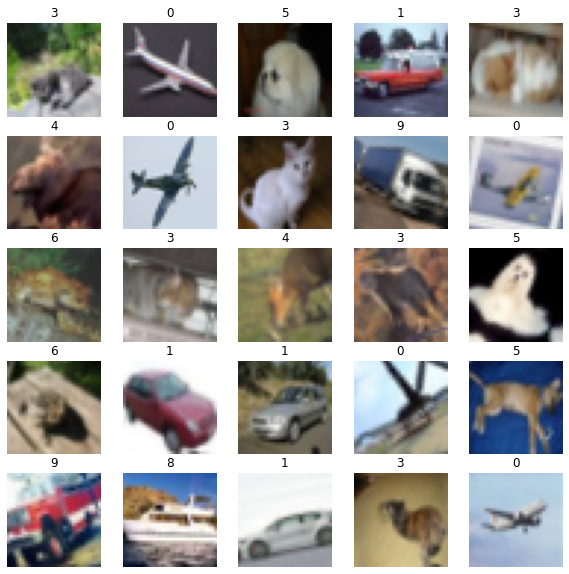

In [ ]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      # plt.title(f'{np.argmax(label_batch[n].numpy())}')
      plt.title(f'{label_batch[n].numpy()}')
      plt.axis('off')
  
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch, label_batch)

print(image_batch.shape, label_batch.shape)

# 🐤 Model

In [ ]:
def GetModel(use_bn):
  return resnet_v1((IMG_HEIGHT, IMG_WIDTH, 3), 20, num_classes=NUM_CLASSES, use_bn=use_bn) ## Returns a ResNet20 model.

tf.keras.backend.clear_session()
test_model = GetModel(use_bn=True)
test_model.summary()
print(f"Total learnable parameters: {test_model.count_params()/1e6} M")

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

# 📲 Callbacks

In [ ]:
earlystopper = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, verbose=0, mode='auto',
    restore_best_weights=True
)

reducelronplateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5,
    patience=3, verbose=1
)

# 🚋 Train with W&B

In [ ]:
tf.keras.backend.clear_session()
# Intialize model
model = GetModel(use_bn=True)
model.compile('adam', 'sparse_categorical_crossentropy', metrics=['acc'])

# Intialize W&B run
run = wandb.init(entity='ayush-thakur', project='nfnet', job_type='train-baseline')

# Train model
model.fit(train_ds,
          epochs=EPOCHS,
          validation_data=val_ds,
          callbacks=[WandbCallback(),
                     reducelronplateau,
                     earlystopper])  

# Evaluate model on test set
loss, acc = model.evaluate(test_ds)
wandb.log({'Test Accuracy': round(acc, 3)})

# Close W&B run
run.finish()

wandb: Currently logged in as: ayush-thakur (use `wandb login --relogin` to force relogin)


Epoch 1/100
 6/42 [===>..........................] - ETA: 9s - loss: 3.3769 - acc: 0.1453 WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1053s vs `on_train_batch_end` time: 0.1457s). Check your callbacks.


42/42 [==============================] - 52s 407ms/step - loss: 2.4727 - acc: 0.2558 - val_loss: 2.8947 - val_acc: 0.1255
Epoch 2/100
42/42 [==============================] - 12s 287ms/step - loss: 1.6787 - acc: 0.4422 - val_loss: 3.1284 - val_acc: 0.1541
Epoch 3/100
42/42 [==============================] - 12s 288ms/step - loss: 1.5324 - acc: 0.5001 - val_loss: 3.0788 - val_acc: 0.1961
Epoch 4/100
42/42 [==============================] - 13s 294ms/step - loss: 1.4334 - acc: 0.5390 - val_loss: 2.6918 - val_acc: 0.2384
Epoch 5/100
42/42 [==============================] - 13s 296ms/step - loss: 1.3722 - acc: 0.5643 - val_loss: 2.2714 - val_acc: 0.3261
Epoch 6/100
42/42 [==============================] - 13s 300ms/step - loss: 1.3038 - acc: 0.5894 - val_loss: 2.2604 - val_acc: 0.3197
Epoch 7/100
42/42 [==============================] - 13s 304ms/step - loss: 1.2393 - acc: 0.6142 - val_loss: 1.6338 - val_acc: 0.4809
Epoch 8/100
42/42 [==============================] - 13s 308ms/step - loss

epoch,70
loss,0.5735
acc,0.84896
val_loss,0.71735
val_acc,0.79667
_runtime,966
_timestamp,1615239954
_step,71
best_val_loss,0.71676
best_epoch,60
Test Accuracy,0.801


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▅▄▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
acc,▁▃▄▅▅▅▆▆▆▇▇▇▇▇▇▇████████████████████████
val_loss,▇█▇▅▃▃▃▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▂▃▅▅▆▇▇▇▇▆▇▇▇▇████████████████████████
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Test Accuracy,▁
